Dataset shape: (7043, 21)


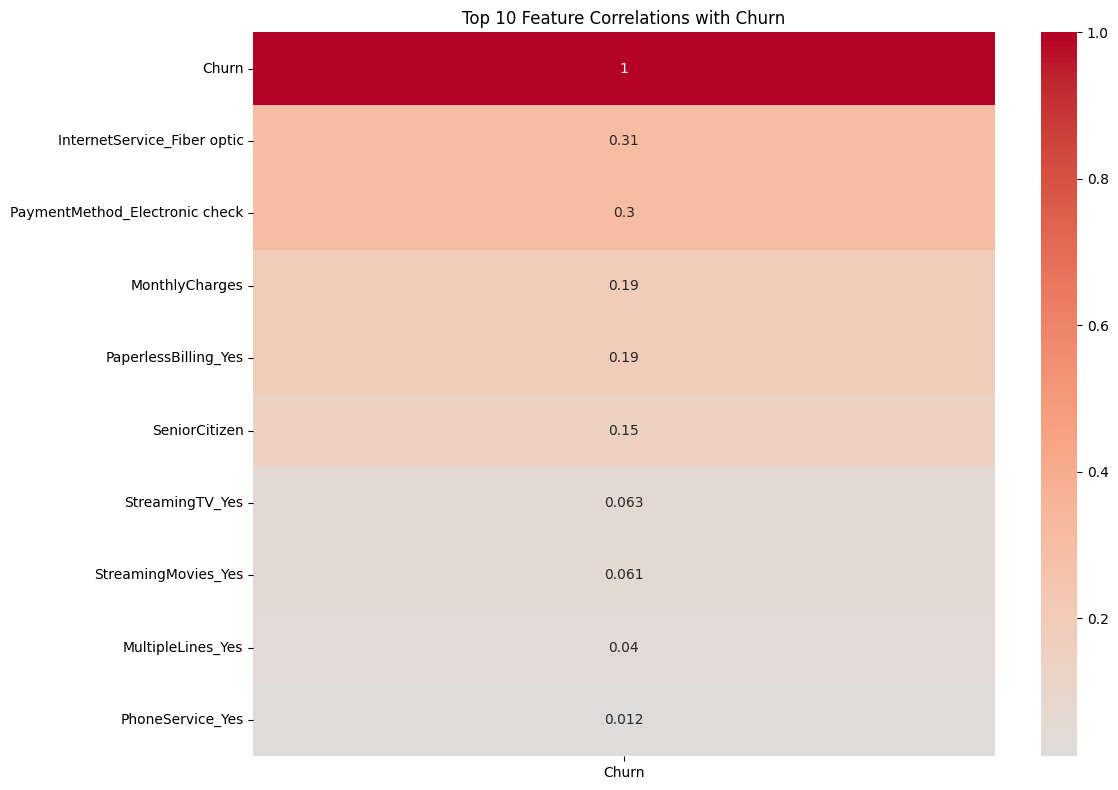

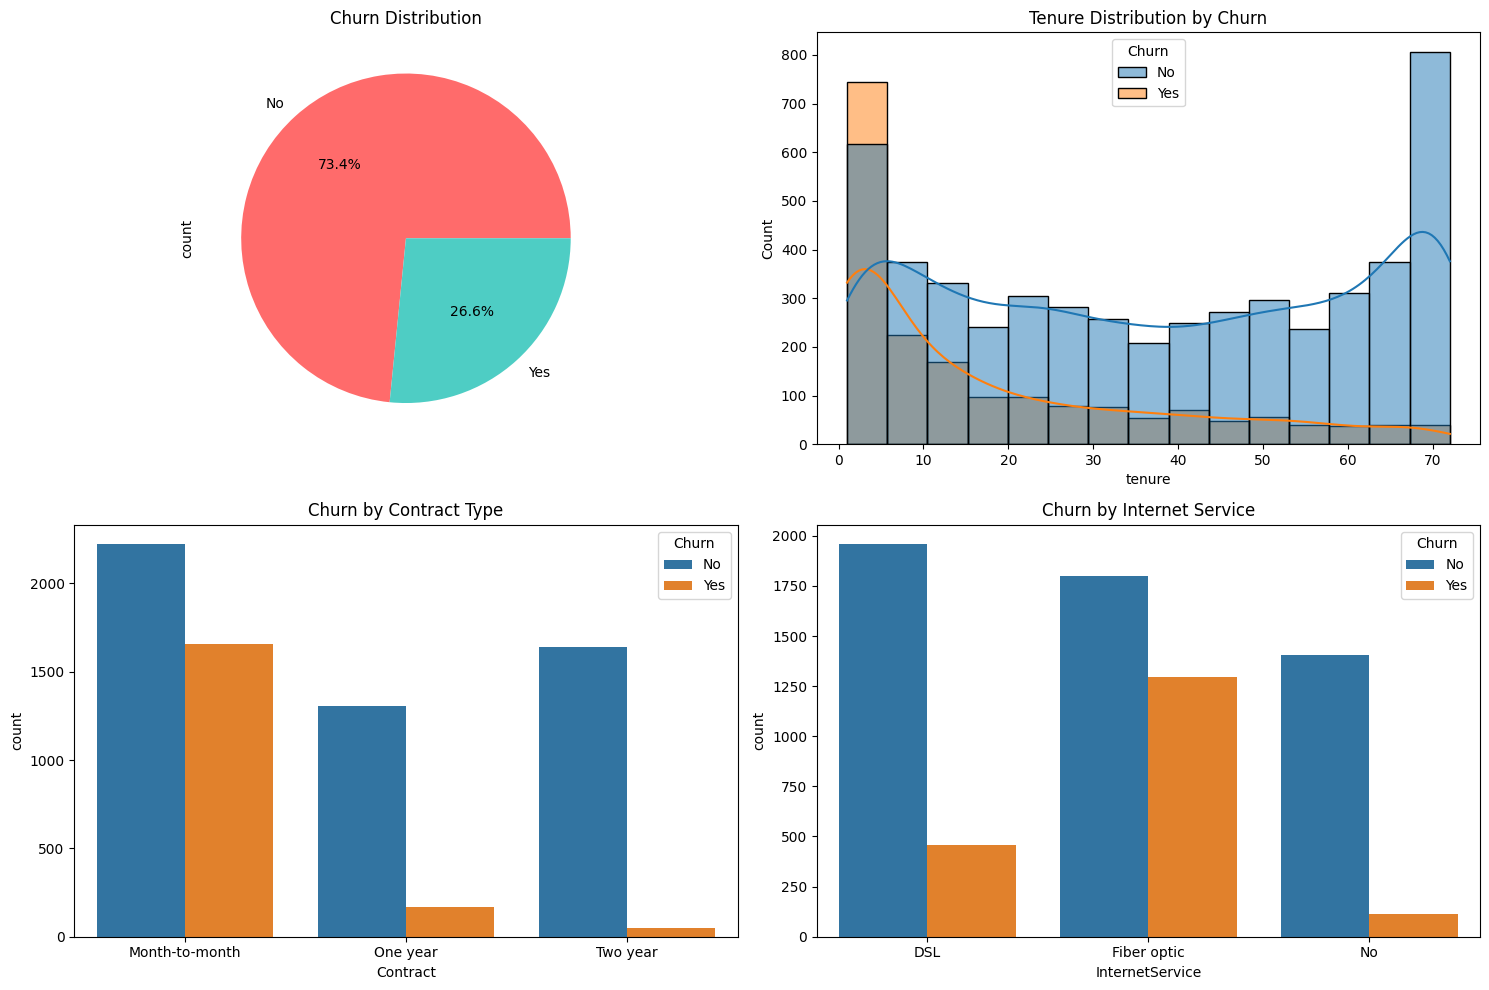

XGBoost Model Performance:
ROC AUC Score: 0.8262

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.77      0.78      0.78      1407


Gradient Boosting (Optimized):
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
ROC AUC Score: 0.8407


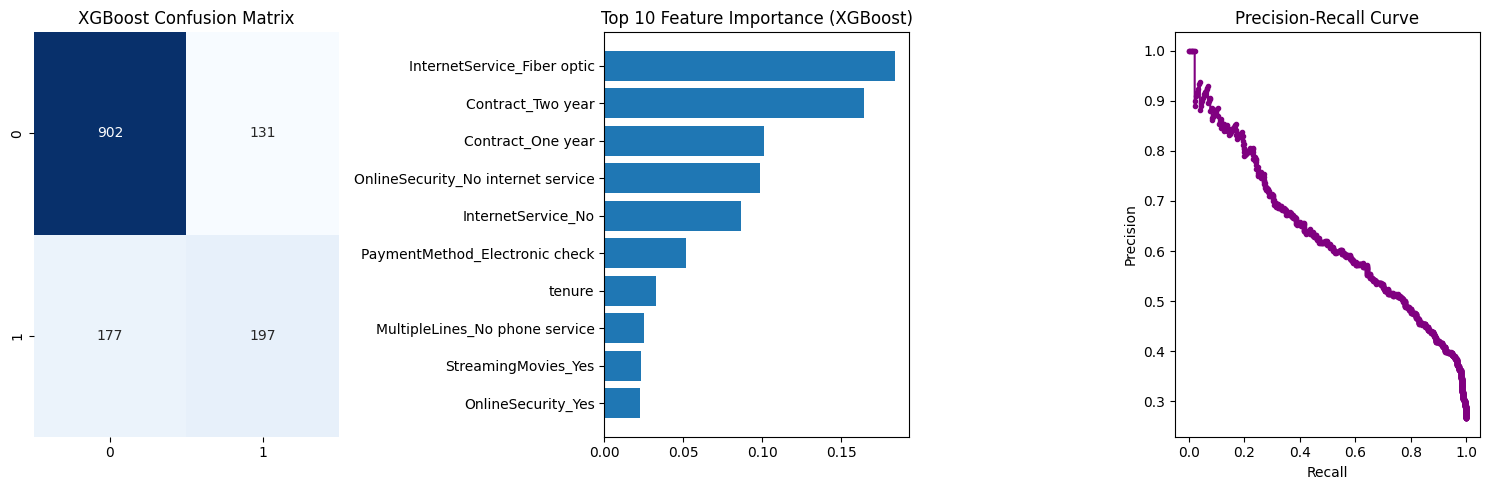


Random Forest Performance:
ROC AUC Score: 0.8343

Model Comparison:
XGBoost: ROC AUC = 0.8262
Gradient Boosting: ROC AUC = 0.8407
Random Forest: ROC AUC = 0.8343


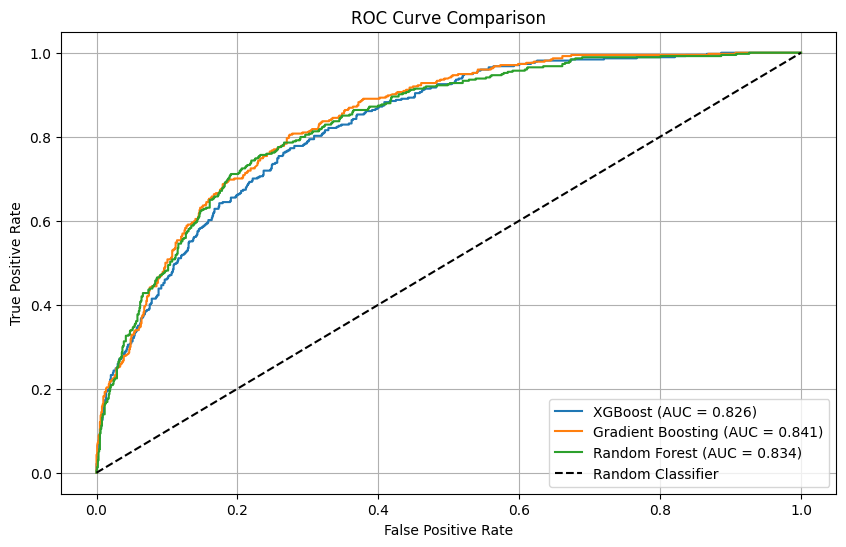


Models saved successfully!
Files created:
- models/churn_model.pkl
- models/scaler.pkl
- models/feature_names.pkl


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")

df = df.drop('customerID', axis=1)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

categorical_columns = df.select_dtypes(include=['object']).columns.drop('Churn')
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
le = LabelEncoder()
df_encoded['Churn'] = le.fit_transform(df_encoded['Churn'])

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

plt.figure(figsize=(12, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix[['Churn']].sort_values(by='Churn', ascending=False).head(10), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Top 10 Feature Correlations with Churn')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[0,0], colors=['#ff6b6b', '#4ecdc4'])
axes[0,0].set_title('Churn Distribution')

sns.histplot(data=df, x='tenure', hue='Churn', ax=axes[0,1], kde=True)
axes[0,1].set_title('Tenure Distribution by Churn')

sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[1,0])
axes[1,0].set_title('Churn by Contract Type')

sns.countplot(data=df, x='InternetService', hue='Churn', ax=axes[1,1])
axes[1,1].set_title('Churn by Internet Service')

plt.tight_layout()
plt.show()

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Model Performance:")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

param_grid_fast = {
    'n_estimators': [100, 150],
    'max_depth': [3, 4],
    'learning_rate': [0.1, 0.15]
}

gb_fast = GradientBoostingClassifier(random_state=42)
grid_fast = GridSearchCV(gb_fast, param_grid_fast, cv=3, scoring='roc_auc', n_jobs=1)
grid_fast.fit(X_train, y_train)

best_gb = grid_fast.best_estimator_
y_pred_gb = best_gb.predict(X_test)
y_pred_proba_gb = best_gb.predict_proba(X_test)[:, 1]

print("\nGradient Boosting (Optimized):")
print(f"Best Parameters: {grid_fast.best_params_}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')

plt.subplot(1, 3, 2)
feature_importance = xgb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importance)[-10:]
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Top 10 Feature Importance (XGBoost)')

plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker='.', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

models = {
    'XGBoost': y_pred_proba,
    'Gradient Boosting': y_pred_proba_gb,
    'Random Forest': y_pred_proba_rf
}

print("\nModel Comparison:")
for name, preds in models.items():
    auc = roc_auc_score(y_test, preds)
    print(f"{name}: ROC AUC = {auc:.4f}")

plt.figure(figsize=(10, 6))
from sklearn.metrics import roc_curve

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_test, preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, preds):.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

import joblib
import os

os.makedirs('models', exist_ok=True)
joblib.dump(xgb_model, 'models/churn_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(X.columns, 'models/feature_names.pkl')

print("\nModels saved successfully!")
print("Files created:")
print("- models/churn_model.pkl")
print("- models/scaler.pkl") 
print("- models/feature_names.pkl")

XGBoost ROC AUC: 0.8142


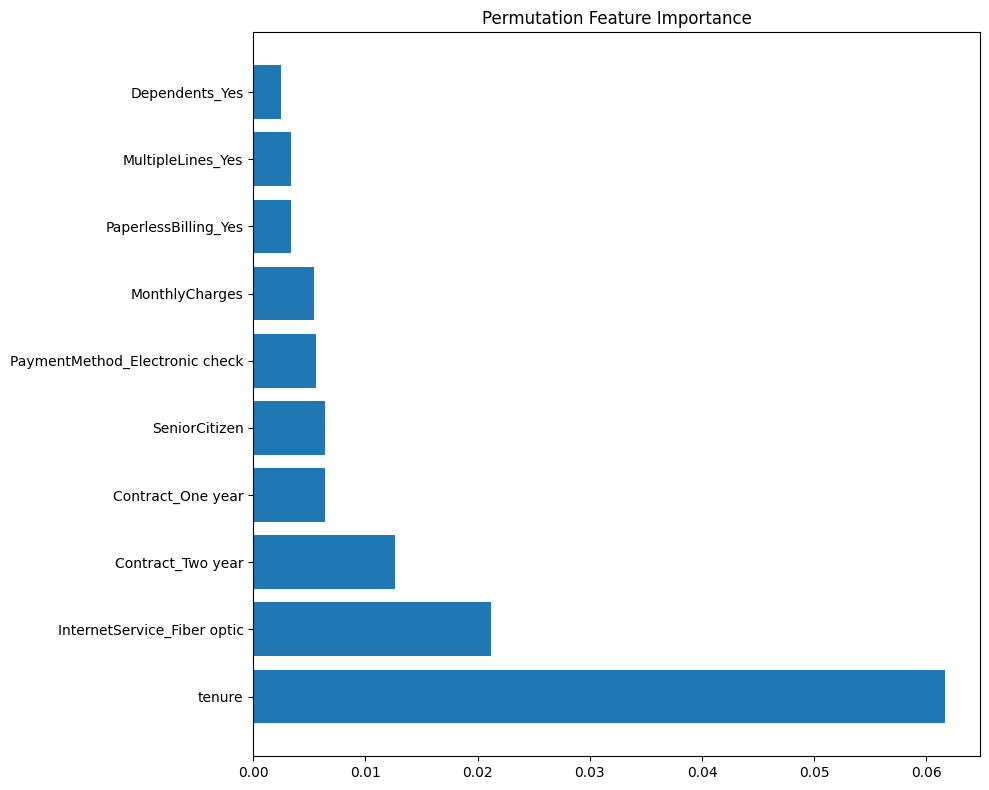

In [4]:
!pip install joblib
import joblib
joblib.dump(best_model, 'models/churn_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(X.columns, 'models/feature_names.pkl')

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print(f"XGBoost ROC AUC: {roc_auc_score(y_test, xgb_y_pred_proba):.4f}")

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 8))
plt.barh(range(10), perm_importance.importances_mean[sorted_idx][:10])
plt.yticks(range(10), [feature_names[i] for i in sorted_idx[:10]])
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()